In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sohampatel26/animal-detection-dataset-cats-dogs-and-pandas")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-detection-dataset-cats-dogs-and-pandas


In [4]:
import os

In [6]:
import os

for root, dirs, files in os.walk(path):
    print("DIR:", root)
    print("Subfolders:", dirs)
    print("Files:", files)
    print("-" * 50)


DIR: /kaggle/input/animal-detection-dataset-cats-dogs-and-pandas
Subfolders: ['archive']
Files: []
--------------------------------------------------
DIR: /kaggle/input/animal-detection-dataset-cats-dogs-and-pandas/archive
Subfolders: ['animals', 'images']
Files: []
--------------------------------------------------
DIR: /kaggle/input/animal-detection-dataset-cats-dogs-and-pandas/archive/animals
Subfolders: ['dogs', 'panda', 'cats']
Files: []
--------------------------------------------------
DIR: /kaggle/input/animal-detection-dataset-cats-dogs-and-pandas/archive/animals/dogs
Subfolders: []
Files: ['dogs_00583.jpg', 'dogs_00683.jpg', 'dogs_00750.jpg', 'dogs_00652.jpg', 'dogs_00895.jpg', 'dogs_00686.jpg', 'dogs_00622.jpg', 'dogs_00291.jpg', 'dogs_00944.jpg', 'dogs_00082.jpg', 'dogs_00955.jpg', 'dogs_00309.jpg', 'dogs_00253.jpg', 'dogs_00416.jpg', 'dogs_00646.jpg', 'dogs_00463.jpg', 'dogs_00688.jpg', 'dogs_00732.jpg', 'dogs_00137.jpg', 'dogs_00602.jpg', 'dogs_00647.jpg', 'dogs_00976.jpg

In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split

source = os.path.join(path, 'archive', 'animals')

def split_dataset(source_dir, dest_dir, train_ratio=0.8):
    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    for cls in classes:
        cls_path = os.path.join(source_dir, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        train_imgs, test_imgs = train_test_split(images, train_size=train_ratio, random_state=42)

        train_cls_path = os.path.join(dest_dir, 'train', cls)
        test_cls_path = os.path.join(dest_dir, 'test', cls)
        os.makedirs(train_cls_path, exist_ok=True)
        os.makedirs(test_cls_path, exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(train_cls_path, img))
        for img in test_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(test_cls_path, img))

# Delete corrupted split folder if needed
if os.path.exists("animal_split_data"):
    shutil.rmtree("animal_split_data")

split_dataset(source, "animal_split_data")


In [10]:
# Confirm all files are valid image formats
valid_exts = [".jpg", ".jpeg", ".png"]
for root, dirs, files in os.walk("animal_split_data/train"):
    for file in files:
        if not any(file.lower().endswith(ext) for ext in valid_exts):
            print("Invalid file found:", file)


In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_data = datasets.ImageFolder('animal_split_data/train', transform=transform)
test_data = datasets.ImageFolder('animal_split_data/test', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print("Classes:", train_data.classes)


Classes: ['cats', 'dogs', 'panda']


In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [16]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_data = datasets.ImageFolder('animal_split_data/train', transform=transform)
test_data = datasets.ImageFolder('animal_split_data/test', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)


Classes: ['cats', 'dogs', 'panda']


In [17]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

model = SimpleCNN().to(device)


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [19]:
num_epochs = 15
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = epoch_loss / len(train_loader)
    accuracy = correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")


Epoch 1/15 | Loss: 0.8660 | Accuracy: 0.5550
Epoch 2/15 | Loss: 0.7240 | Accuracy: 0.6333
Epoch 3/15 | Loss: 0.6323 | Accuracy: 0.6829
Epoch 4/15 | Loss: 0.5336 | Accuracy: 0.7479
Epoch 5/15 | Loss: 0.4836 | Accuracy: 0.7783
Epoch 6/15 | Loss: 0.3763 | Accuracy: 0.8308
Epoch 7/15 | Loss: 0.2832 | Accuracy: 0.8804
Epoch 8/15 | Loss: 0.2172 | Accuracy: 0.9100
Epoch 9/15 | Loss: 0.1696 | Accuracy: 0.9333
Epoch 10/15 | Loss: 0.1278 | Accuracy: 0.9508
Epoch 11/15 | Loss: 0.0950 | Accuracy: 0.9654
Epoch 12/15 | Loss: 0.0748 | Accuracy: 0.9754
Epoch 13/15 | Loss: 0.0553 | Accuracy: 0.9796
Epoch 14/15 | Loss: 0.0419 | Accuracy: 0.9846
Epoch 15/15 | Loss: 0.0394 | Accuracy: 0.9858


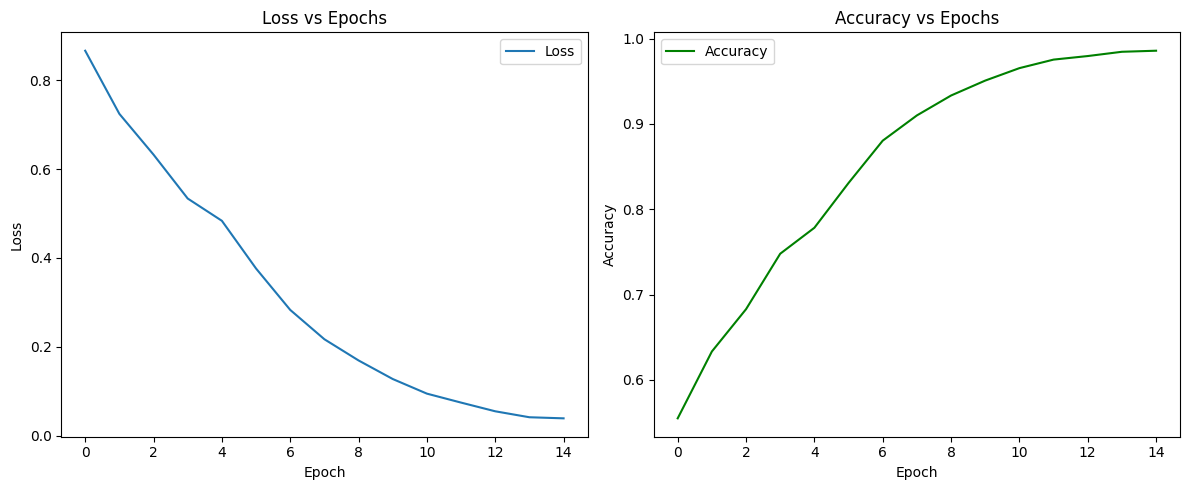

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy', color='green')
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.7117


In [26]:
torch.save(model.state_dict(), 'animal_cnn.pth')  # or use full path like '/content/animal_cnn.pth'


In [27]:
import torch
from PIL import Image
import torchvision.transforms as transforms

# Make sure this matches the transform used in your training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load the trained model
model = model # Replace with your model class name if different
model.load_state_dict(torch.load('animal_cnn.pth', map_location=torch.device('cpu')))
model.eval()

# Custom image path (replace with your test image)
image_path = '/content/download (2).jpg'  # Upload the image and update path

# Load and preprocess image
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)  # Add batch dimension

# Predict
with torch.no_grad():
    output = model(image)
    predicted_class = torch.argmax(output, dim=1).item()

# Class mapping
class_names = ['cats', 'dogs', 'pandas']  # Update if needed

print(f"Predicted class: {class_names[predicted_class]}")


Predicted class: dogs
